# Hillslope Demo: Integrated Hydrology + Reactive Transport

## Summary

The hillslope is a fundamental system of headwater watersheds. Hillslopes are considered key in order to understand both catchment runoff generation and biogeochemical exports.

This demo considers a simplified representation of a headwater catchment hillslope. The simulation seeks to capture its hydrological and geochemical response to evolving precipitation inputs over a period of 200 days that include wet and dry periods. Over most of the hillslope rainwater infiltrates into the subsurface, flows downgradient and discharges to the surface near the hillslope toe. During wet periods, groundwater discharge mixes with rain water in this region of the surface. During dry periods, surface water in this region is exclusively from groundwater dicharge.

The geochemical problem considers only the carbonate system with 5 primary species, 6 secondary (equilibrium) complexes, and calcite. Aqueous complexation is considered both in the surface and subsurface domains, while calcite dissolution is considered only in the subsurface domain. Rainwater drives calcite dissolution in the subsurface before it equilibrates at depth. Two non-reactive tracers, one in the subsurface and one in the rainwater, are used to unravel mixing processes.

## Run the simulation

Two input files are provided, which set up the same problem, with PFLOTRAN and CrunchFlow as geochemical engines, respectively. They simulate 200 days and may take > 15 mins using two processors, depending on your computer. 

* hillslope_calcite_pflotran.xml 
* hillslope_calcite_crunch.xml

Two additional input files are provided which restart the two previous runs from a checkpoint file obtained at day 50. The simulation time is shortened with these as they skip the initial 50 days of drainage. They used the checkpoint files in the "./restart" directory.

* hillslope_calcite_pflotran_restart.xml 
* hillslope_calcite_crunch_restart.xml 

Note that the checkpoint files in the "./restart" directory are generated using two processors. The restart/continuing simulation should use the same number of processors as how the checkpoint files are generated (in this case, always run with 2 processors).

Pick your geochemical engine and the simulation:

```sh
(base) ats_sc_user@e2614fb043da:~/short-course/03_reactive_transport$ nohup mpirun -n 2 ../ats --xml_file=hillslope_calcite_pflotran_restart.xml > log &
```

Keep track of the simulation status:

```sh
(base) ats_sc_user@e2614fb043da:~/short-course/03_reactive_transport$ tail -f log | grep -e Cycle
```

In [2]:
# Update your engine if needed
MYENGINE='pflotran'
#MYENGINE='crunchflow'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
from IPython.display import Image

## Domain and Boundary Conditions

The hillslope is 1000-m long and 45-m deep with a slope of 0.1.

* **Subsurface domain**: The upstream, downstream and bottom boundaries of the subsurface domain are no-flow boundaries. The top boundary is coupled with surface domain. 

* **Surface domain**: Rain is applied as a source terms in the surface flow PK. A free flow (seepage face) boundary condition is set at the hillslope toe (green dot in the figure).

<img src="./hillslope/pictures/hillslope_mesh_and_bc.png" alt="Drawing" style="width: 800px;"/>



## Integrated Hydrology

The initial condition of integrated hydrology is set as -10 meters of "hydrostatic head", meaning water table 10 meters below the ground surface. <br>

```xml
      <ParameterList name="initial condition" type="ParameterList">
        <Parameter name="hydrostatic head [m]" type="double" value="-10.0" />
        <Parameter name="hydrostatic water density [kg m^-3]" type="double" value="1000.0" />
      </ParameterList>
```
<img src="./hillslope/pictures/saturation_liquid_ic.png" alt="Drawing" style="width: 800px;"/>


Periodic rainfall is the only source of water in the model, alternating dry with wet cycles with rain of different intensity. Below are the values of recharge applied uniformly on the surface at an observation point. <br>

```xml
      <ParameterList name="surface-water_source">
        <Parameter name="field evaluator type" type="string" value="independent variable" />
        <ParameterList name="function">
          <ParameterList name="domain rain">
            <Parameter name="region" type="string" value="surface" />
            <Parameter name="component" type="string" value="cell" />
            <ParameterList name="function">
              <ParameterList name="function-tabular">
                <Parameter name="x values" type="Array(double)" value="{0.0,4320000,6480000,8640000,10800000,12960000}" />
                <Parameter name="y values" type="Array(double)" value="{0e-07,1e-06,0e-07,2e-06,0e-7,1e-06}" />
                <Parameter name="forms" type="Array(string)" value="{constant,constant,constant,constant,constant}" />
              </ParameterList>
            </ParameterList>
          </ParameterList>
        </ParameterList>
      </ParameterList>
```

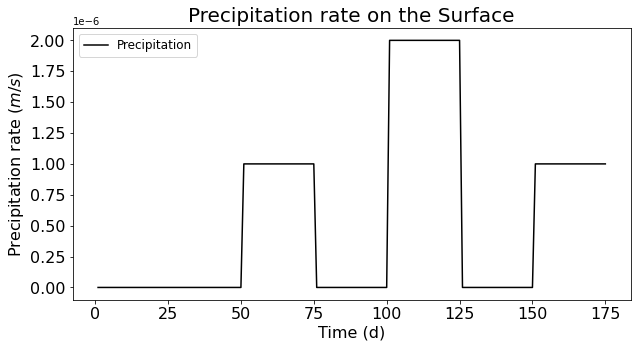

In [4]:
plt.rcParams['figure.figsize'] = [10, 5]
path='./hillslope/results/'
RECHARGE = np.loadtxt(path+'surface-water_source.dat', skiprows=12) 

plt.plot(RECHARGE[:,0]/86400, RECHARGE[:,1], 'k-', label='Precipitation')
plt.title("Precipitation rate on the Surface", fontsize=20)
plt.xlabel("Time (d)",fontsize=16)
plt.ylabel("Precipitation rate ($m/s$)",fontsize=16)
plt.xticks([0,25,50,75,100,125,150,175],fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.show()

The flow rate (surface-mass_flux) at the observation point of the hillslope toe (on the surface) shows quick initial drainage, which slows down with time and is followed by subsequent increases in response to precipitation cycles. The hillslope is draining during the entire simulated time. 

In the first 50 days, flow is all groundwater as no precipitation is assumed in the simulation. <br>
In the period of 50-75 days when rain starts, flow is a mixing of groundwater and surface water. 

In [5]:
# ATS raw output units are mol/s
# Convert to m3/s by dividing by the molar density of the solution 
unit_convert_flow = 1.8e-5

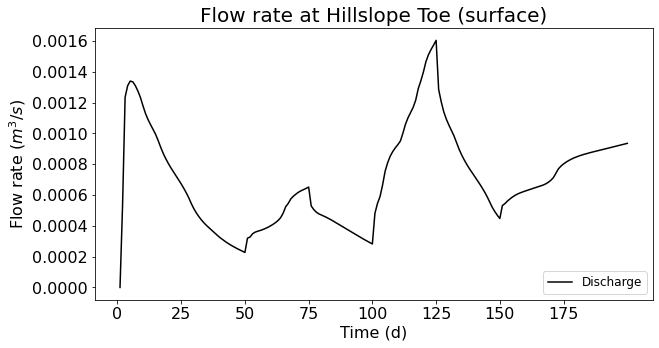

In [6]:
plt.rcParams['figure.figsize'] = [10, 5]
path='./hillslope/results/'
DISCHARGE = np.loadtxt(path+'surface_outlet_flux_crunch.dat', skiprows=12) 

plt.plot(DISCHARGE[:,0]/86400, DISCHARGE[:,1]*unit_convert_flow, 'k-', label='Discharge')
plt.title("Flow rate at Hillslope Toe (surface)", fontsize=20)
plt.xlabel("Time (d)",fontsize=16)
plt.ylabel("Flow rate ($m^3/s$)",fontsize=16)
plt.xticks([0,25,50,75,100,125,150,175],fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12, loc='lower right')
plt.show()

Velocity vectors show the flow pattern in the subsurface, with an upward velocity vector near the hillslope toe, indicating subsurface discharge (Visualized using VisIt). <br>

<img src="./hillslope/pictures/hillslope_flow_velocity.png" alt="Drawing" style="width: 800px;"/>

Please feel free to watch the video of saturation liquid fluctuation over time showing in the ./pictures directory.

## Reactive Transport

We consider transport of 11 species, of which 5 are primary and 6 secondary. Only total component concentrations are transported by Amanzi-ATS, thus must be specified in each of the Transport PKs, with the same name and in the same order as the primary species in the geochemical engine. For example, for subsurface transport:

```xml
    <ParameterList name="subsurface transport">
      <Parameter name="PK type" type="string" value="transport ats" />
      <Parameter name="saturation liquid key" type="string" value="saturation_liquid" />
      <Parameter name="previous saturation liquid key" type="string" value="prev_saturation_liquid" />
      <Parameter name="flux_key" type="string" value="mass_flux" />
      <Parameter name="molar_density_key" type="string" value="molar_density_liquid" />
      <Parameter name="component names" type="Array(string)" value="{H+, HCO3-, Ca++, Tracer1}" />
      <Parameter name="number of liquid components" type="int" value="5" />
```

ATS supports two geochemical engines, PFLOTRAN and CrunchFlow. The geochemical system is defined in their input files, in the diretory "./data". Note that the names of the secondary species need not be given in Amanzi-ATS.

For PFLOTRAN:

```ini
CHEMISTRY
  PRIMARY_SPECIES
    H+
    HCO3
    Ca++
    Tracer1
  /
  SECONDARY_SPECIES
    OH-
    CO3--
    CO2(aq)
    CaOH+
    CaHCO3+
    CaCO3(aq)
  /
```

For CrunchFlow

```css
PRIMARY_SPECIES
H+
HCO3-
Ca++
Tracer1
END

SECONDARY_SPECIES
OH-
CO3--
CO2(aq)
CaOH+
CaHCO3+
CaCO3(aq)
END
```

Calcite is the only mineral considered. The name of each mineral must be entered in the input file


```xml
<Parameter name="minerals" type="Array(string)" value="{Calcite}" />
```

The dissolution reaction is defined in the respective engines files. 

In PFLOTRAN:

```ini
  MINERALS
    Calcite
  /
  MINERAL_KINETICS
    Calcite
      PREFACTOR
        RATE_CONSTANT -0.05 
	PREFACTOR_SPECIES H+
	  ALPHA 1.0d0
        /
      /
      PREFACTOR
        RATE_CONSTANT -3.30
        PREFACTOR_SPECIES CO2(aq)
	  ALPHA 1.0d0
	/
      /
      PREFACTOR
        RATE_CONSTANT -6.19
      /
    /
  /
```

In CrunchFlow:

```css
MINERALS
Calcite             -label leichou1    -rate   -0.05
Calcite             -label leichou2    -rate   -3.30
Calcite             -label leichou3    -rate   -6.18
END
```



## Sources and ICs for transport

<img src="./hillslope/pictures/hillslope_mesh_and_bc.png" alt="Drawing" style="width: 800px;"/>

The only external **source** of solutes is in the rain water. As with the surface flow problem, in the surface transport PK, a source term of solutes must specified in the surface. Here it is done as a geochemical condition named **rain**:

```xml
      <ParameterList name="source terms">
        <ParameterList name="geochemical" type="ParameterList">
          <ParameterList name="Tracer injection" type="ParameterList">
            <Parameter name="regions" type="Array(string)" value="{surface domain}" />
            <Parameter name="solutes" type="Array(string)" value="{H+, HCO3-, Ca++, Tracer1}" />
            <Parameter name="times" type="Array(double)" value="{0.0,8640000.0}" />
            <Parameter name="geochemical conditions" type="Array(string)" value="{rain, rain}" />
            <Parameter name="time functions" type="Array(string)" value="{constant}" />
            <Parameter name="ats units [moles/m^3]" type="bool" value="true" />
          </ParameterList>
        </ParameterList>
        <ParameterList name="component mass source">
        </ParameterList>
      </ParameterList>
```

The condition name must match the one available in the engine's input file (it is case-sensitive). Rainwater is equlibrated with atmospheric CO2:

In PFLOTRAN:

```ini
CONSTRAINT rain 
  CONCENTRATIONS
    H+      5.         Z   
    HCO3    3.15e-4    G  CO2(g)  
    Ca++    1.d-10     T
    Tracer1 1.d-10     T
  /
END
```
In CrunchFlow:

```css
Condition rain
units     mol/kg
temperature      25.0
pH               charge
HCO3-            CO2(g)   3.15E-4
Ca++             1.e-10
Tracer1          1.e-10
Calcite          0.0      bulk_surface_area  0.0
END
```

We use the initial conditions in chemistry PKs to specify the presence (subsurface) or absence (surface) of calcite. This is done in the engine input file, where the volume fraction and surface area are specified. For example, the initial condition in the subsurface is named "initial", and in the surface is named "surfini".

Subsurface: <br>
```xml
      <ParameterList name="initial condition" type="ParameterList">
        <ParameterList name="geochemical conditions" type="ParameterList">
          <ParameterList name="initial" type="ParameterList">
            <Parameter name="regions" type="Array(string)" value="{computational domain}" />
          </ParameterList>
        </ParameterList>
      </ParameterList>
```
Surface: <br>
```xml
      <ParameterList name="initial condition" type="ParameterList">
        <ParameterList name="geochemical conditions" type="ParameterList">
          <ParameterList name="surfini" type="ParameterList">
            <Parameter name="regions" type="Array(string)" value="{surface domain}" />
          </ParameterList>
        </ParameterList>
      </ParameterList>
```

In PFLOTRAN (subsurface and surface):

```ini
CONSTRAINT initial 
  CONCENTRATIONS
    H+      1.d-8      Z   
    HCO3    1.d-3      M  Calcite
    Ca++    1.d-3      T
    Tracer1 1.d-3      T
  /
  MINERALS
    Calcite 1.d-2      1.0d0 
  /
END

CONSTRAINT surfini 
  CONCENTRATIONS
    H+       1.d-8     Z   
    HCO3     1.d-3     M  Calcite
    Ca++     1.d-3     T
    Tracer1  1.d-3     T
  /
END
```
In CrunchFlow (subsurface and surface):

```css
Condition initial
units     mol/kg
temperature      25.0
SolidDensity     2700.0
pH               charge
HCO3-            Calcite
Ca++             1.0e-3
Tracer1          1.0e-3
Calcite          1.0e-2             bulk_surface_area  1.0
END

Condition surfini
units     mol/kg
temperature      25.0
SolidDensity     2700.0
pH               charge
HCO3-            Calcite
Ca++             1.0e-3   
Tracer1          1.0e-3
!Mineral        <volume fraction>  <bulk surface area> m^2 /m^3
Calcite          0.0             bulk_surface_area  0.0
END


```

## Geochemical exports

The concentration breakthrough curves are evaluated at the hillslope toe on the surface. The effluent chemical exports present the mixing processes and calcite reaction simulated within the hillslope domain.  <br>

Key points: <br>
1) Tracer1 has the same initial and boundary conditions as Ca++, therefore, the difference between Tracer1 and Ca++ is due to calcite reaction <br>

2) Species concentrations decrease when recharge period starts, because their concentrations are low in the rain water that mixing with groundwater in the surface flow at the hillslope toe. 


In [20]:
plt.rcParams['figure.figsize'] = [10, 5]
path='./hillslope/results'
BTC_1 = np.loadtxt(path+'surface_total_concentration_pflotran.dat', skiprows=12) 
FREE_1 = np.loadtxt(path+'surface_free_ion_species_pflotran.dat', skiprows=12) 

OSError: ./hillslope/resultssurface_total_concentration_pflotran.dat not found.

array([[4.40640000e+06, 3.98590720e-07, 2.62569271e-05, 1.29291719e-05,
        1.23918255e-05],
       [4.49280000e+06, 4.15556556e-07, 2.64970909e-05, 1.30407861e-05,
        1.25134697e-05],
       [4.57920000e+06, 4.57778851e-07, 2.70655710e-05, 1.33039184e-05,
        1.28024146e-05],
       [4.66560000e+06, 4.86165789e-07, 2.74176200e-05, 1.34657518e-05,
        1.29824119e-05],
       [4.75200000e+06, 5.01623722e-07, 2.76037559e-05, 1.35510932e-05,
        1.30777919e-05],
       [4.83840000e+06, 5.13176585e-07, 2.77463173e-05, 1.36165976e-05,
        1.31507094e-05],
       [4.92480000e+06, 5.25212166e-07, 2.78971535e-05, 1.36859980e-05,
        1.32277705e-05],
       [5.01120000e+06, 5.38466202e-07, 2.80627985e-05, 1.37626845e-05,
        1.33119503e-05],
       [5.09760000e+06, 5.53214647e-07, 2.82454349e-05, 1.38475874e-05,
        1.34044337e-05],
       [5.18400000e+06, 5.69179976e-07, 2.84415170e-05, 1.39388214e-05,
        1.35036495e-05],
       [5.27040000e+06, 5.8629

In [21]:
# ATS raw output unit: mol-species/mol-water in surface_total_concentration_crunch.dat
# Convert to micromole per liter
unit_convert_transport = 55.55e6

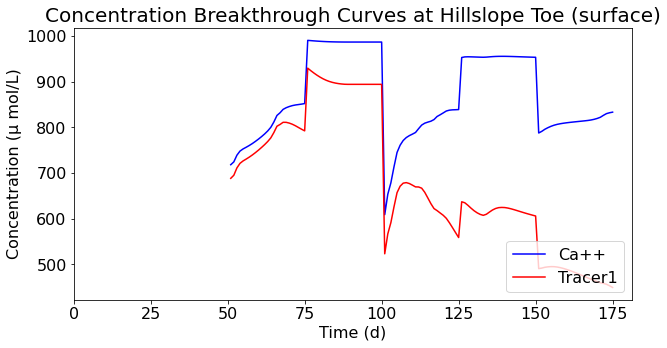

In [22]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(BTC_1[:,0]/86400, BTC_1[:,3]*unit_convert_transport, 'b-', BTC_1[:,0]/86400, BTC_1[:,4]*unit_convert_transport, 'r-')
plt.title("Concentration Breakthrough Curves at Hillslope Toe (surface)", fontsize=20)
plt.xlabel("Time (d)",fontsize=16)
plt.ylabel("Concentration (\u03BC mol/L)",fontsize=16)
plt.xticks([0,25,50,75,100,125,150,175],fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Ca++', 'Tracer1'], fontsize=16, loc='lower right')
plt.show()

Volume fraction of Calcite at the end of the simulation, showing that calcite dissolves on the top of the subsurface domain (visualized using VisIt)<br>
<img src="./hillslope/pictures/volume_fraction_calcite.png" alt="Drawing" style="width: 1000px;"/>

# Exercises

1) Add the second tracer in the ATS and PFLOTRAN/CrunchFlow input files with relatively higher concentration (1e-3）in the rain water, and low concentration (1e-10) in the inital conditions. <br>
2) Try to modify the ATS input to run with another mesh file (in "./mesh/hillslope_refined_resolution.exo") <br>

Hints for Exercise 1): <br>
Need to change the ATS xml input
```xml
      <Parameter name="component names" type="Array(string)" value="{H+, HCO3-, Ca++, Tracer1, Tracer2}" />
      <Parameter name="number of liquid components" type="int" value="5" />
...
      <Parameter name="number of aqueous components" type="int" value="5" />
...
      <ParameterList name="source terms">
        <ParameterList name="geochemical" type="ParameterList">
          <ParameterList name="Tracer injection" type="ParameterList">
            <Parameter name="regions" type="Array(string)" value="{surface domain}" />
            <Parameter name="solutes" type="Array(string)" value="{H+, HCO3-, Ca++, Tracer1, Tracer2}" />
...
    <ParameterList name="surface total concentration" type="ParameterList">
      <Parameter name="variable" type="string" value="surface-total_component_concentration" />
      <Parameter name="region" type="string" value="east conc" />
      <Parameter name="functional" type="string" value="average" />
      <Parameter name="delimiter" type="string" value=" " />
      <Parameter name="location name" type="string" value="cell" />
      <Parameter name="write interval" type="int" value="1" />
      <Parameter name="number of vectors" type="int" value="5" />
      <Parameter name="observation output filename" type="string" value="surface_total_concentration_crunch.dat" />
      <Parameter name="times start period stop" type="Array(double)" value="{0.0,86400.0,-1.0}" />
    </ParameterList>         

```

Add Tracer2 in the PFLOTRAN or CrunchFlow input file: <br>
PFLOTRAN :

```ini
  PRIMARY_SPECIES
    H+  
    HCO3
    Ca++
    Tracer1
    Tracer2
...
CONSTRAINT rain 
  CONCENTRATIONS
    H+      5.         Z   
    HCO3    3.15e-4    G  CO2(g)  
    Ca++    1.d-10     T
    Tracer1 1.d-3      T
    Tracer2 1.d-10     T
  /
END

```
CrunchFlow:
```css
PRIMARY_SPECIES
H+
HCO3-
Ca++
Tracer1
Tracer2
END
...
Condition initial
units     mol/kg
temperature      25.0
SolidDensity     2700.0
pH               charge
HCO3-            Calcite
Ca++             1.0e-3
Tracer1          1.0e-10
Tracer2          1.0e-3
!Mineral        <volume fraction>  <bulk surface area> m^2 /m^3
Calcite          1.0e-2             bulk_surface_area  1.0 
END
```

And PFLOTRAN/CrunchFlow database file:
PFLOTRAN:
```ini
'Tracer2' 0.0 0.0 1.0
```

CrunchFlow:
```css
'Tracer2'  0 0 0
```

Mixing of surface water and subsurface groundwater is observed in the breakthrough curves. During the rain period, Tracer2 concentration increase immediately because its concentration is higher in the rain. Later in the rain period, the mixing of groundwater with lower concentration and surface water with higher concentration determines the breakthourgh curves measured at the hillslope toe. Note that with rain falls on the surface, infiltration also push more groundwater flowing out of the hillslope.

Text(0.5, 1.0, 'Breakthrough Curves of Concentrations')

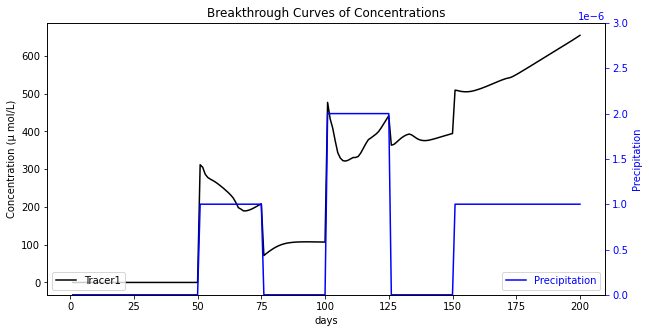

In [10]:
path='./hillslope/add_tracer2/'
RECHARGE = np.loadtxt(path+'surface-water_source.dat', skiprows=12) 
BTC_1 = np.loadtxt(path+'surface_total_concentration_crunch.dat', skiprows=12) 

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(111)
ax1.set_xlabel('days')
ax1.set_ylabel('Concentration (\u03BC mol/L)', color='k')
ax1.plot(BTC_1[:,0]/86400, BTC_1[:,5]*unit_convert_transport, 'k-',)
ax1.tick_params(axis='y', labelcolor='k')
# ax1.set_ylim((600, 1000))
ax1.legend(['Tracer1'], loc='lower left')

# For pH calculation we should use free H+ concentration
ax2 = ax1.twinx()
ax2.plot(RECHARGE[:,0]/86400, RECHARGE[:,1], 'b')
ax2.set_ylabel('Precipitation', color='b')
ax2.legend(['Precipitation'], loc='lower right', labelcolor = 'b')
ax2.tick_params(axis='y', colors='b')
ax2.set_ylim((0, 3e-6))

ax1.set_title('Breakthrough Curves of Concentrations')
# ax1.xticks([0,25,50,75,100,125,150,175])